In [1]:
import os
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
delhi_hchos = glob.glob('HCHO_tifs/*.tif')

In [3]:
len(delhi_hchos)

81

In [4]:
delhi_no2s = glob.glob('NO2_tifs/*.tif')

In [5]:
len(delhi_no2s)

81

In [6]:
delhi_fnrs = glob.glob('FNR/*.tif')
delhi_fnrs = [tif for tif in delhi_fnrs if len(tif)==25]

In [7]:
len(delhi_fnrs)

62

In [8]:
# Convert tiff to aray
import numpy as np
import rasterio

def tiff_to_array_rasterio(file_path):
    # Open the TIFF file
    with rasterio.open(file_path) as src:
        # Read the image data
        img_array = src.read()
        # Optionally, you may want to read metadata
        meta = src.meta
        xmin, ymin, xmax, ymax = src.bounds

    
    return img_array, meta, xmin, ymin, xmax, ymax


# Seasonal FNR Trends

In [9]:
total_hchos = []
for hcho in delhi_hchos:
    hcho_array, meta, xmin, ymin, xmax, ymax = tiff_to_array_rasterio(hcho)
    # Replace negative values with zero
    hcho_array[hcho_array < 0] = 0
    total_hcho = hcho_array.sum()
    total_hchos.append(total_hcho)


fnr = np.array(total_hchos)/np.array(total_no2s)

In [24]:
total_fnrs = []
years = []
months = []
for fnr in delhi_fnrs:
    fnr_array, meta, xmin, ymin, xmax, ymax = tiff_to_array_rasterio(fnr)
    # Replace negative values with zero
    fnr_array[fnr_array < 0] = 0
    total_fnr = np.nanmean(fnr_array)
    total_fnrs.append(total_fnr)
    years.append(re.findall(r'\d{4}', fnr)[0])
    months.append(fnr.split('_')[-2])

In [29]:
fnr_df = pd.DataFrame([years, months, total_fnrs]).T
fnr_df.columns = ['year', 'month', 'fnr']
fnr_df['mm-yy'] = fnr_df['month']+'-'+'01'
fnr_df

,year,month,fnr,mm-yy
0,2019,Apr,3.624167,Apr-01
1,2019,Aug,5.108828,Aug-01
2,2019,Dec,1.9675,Dec-01
3,2019,Feb,2.873008,Feb-01
4,2019,Jan,1.865174,Jan-01
...,...,...,...,...
57,2023,Nov,3.433052,Nov-01
58,2023,Oct,3.374913,Oct-01
59,2023,Sep,3.966846,Sep-01
60,2024,Feb,2.709535,Feb-01


In [30]:
fnr_df_pivot = pd.pivot_table(fnr_df,
                          index=['mm-yy'],
                          columns='year',
                          values='fnr').reset_index()
fnr_df_pivot.set_index('mm-yy',inplace=True)
fnr_df_pivot

year,2019,2020,2021,2022,2023,2024
mm-yy,,,,,,
Apr-01,3.624167,5.2145,3.458387,2.947048,3.046368,NaN
Aug-01,5.108828,5.322834,4.761591,4.409909,4.87184,NaN
Dec-01,1.9675,2.015611,1.911169,1.605483,2.117851,NaN
Feb-01,2.873008,2.591103,2.127666,1.864473,2.163405,2.709535
Jan-01,1.865174,1.7911,1.49814,1.521505,1.411626,1.370026
Jul-01,4.455833,5.332433,4.040076,4.523169,5.363853,NaN
Jun-01,4.096149,5.42129,4.389989,3.81916,4.791223,NaN
Mar-01,3.41553,3.806115,2.92686,3.216742,3.208483,NaN
May-01,3.838876,4.725355,4.767528,3.84342,3.638404,NaN


In [36]:
## SORT THE  DATETIME INDEX WHICH IS IN STRING FORMAT ##
# Convert the index to datetime
fnr_df_pivot.index = pd.to_datetime(fnr_df_pivot.index + '-2000', format='%b-%d-%Y')
# Sort the DataFrame by the datetime index
fnr_df_pivot = fnr_df_pivot.sort_index()
# Remove the year from the index
fnr_df_pivot.index = fnr_df_pivot.index.strftime('%b-%d')
fnr_df_pivot = fnr_df_pivot.drop('2024', axis=1)
fnr_df_pivot

year,2019,2020,2021,2022,2023
mm-yy,,,,,
Jan-01,1.865174,1.7911,1.49814,1.521505,1.411626
Feb-01,2.873008,2.591103,2.127666,1.864473,2.163405
Mar-01,3.41553,3.806115,2.92686,3.216742,3.208483
Apr-01,3.624167,5.2145,3.458387,2.947048,3.046368
May-01,3.838876,4.725355,4.767528,3.84342,3.638404
Jun-01,4.096149,5.42129,4.389989,3.81916,4.791223
Jul-01,4.455833,5.332433,4.040076,4.523169,5.363853
Aug-01,5.108828,5.322834,4.761591,4.409909,4.87184
Sep-01,4.174777,4.847307,3.673795,4.169714,3.966846


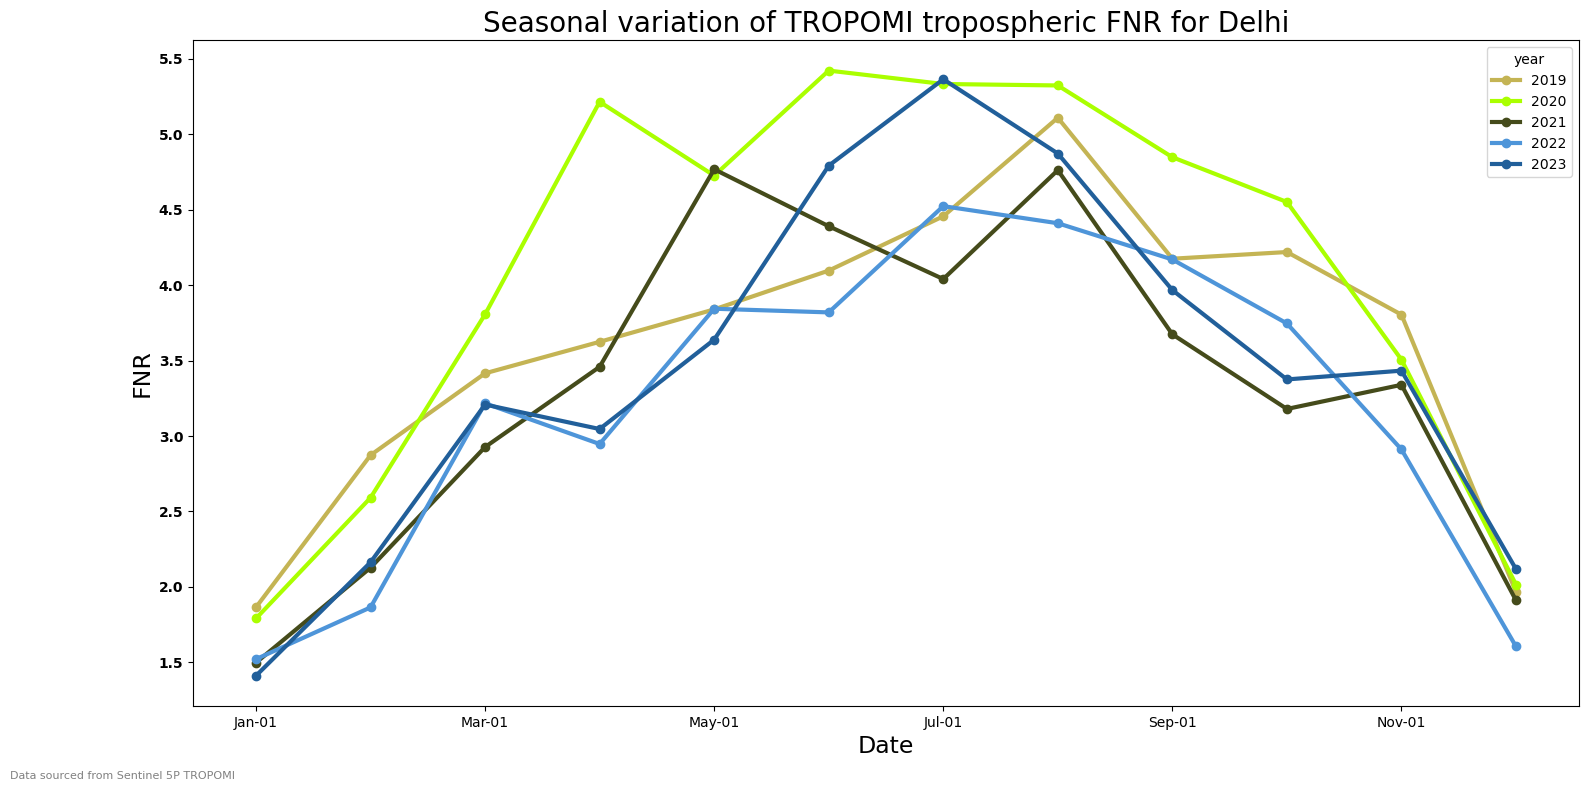

In [41]:
color_dict = {
              '2019': '#C4B454',
              '2020': '#AAFF00',
              '2021': '#454B1B',
              '2022': '#4e95d9',
              '2023': '#215f9a',
              }
fnr_df_pivot.plot(figsize=(16, 8),
                       color=[color_dict.get(x) for x in fnr_df_pivot.columns],
                       linewidth = 3,
                 marker='o')

plt.title('Seasonal variation of TROPOMI tropospheric FNR for Delhi', fontsize=20)
plt.xlabel('Date', fontsize=17)
plt.ylabel('FNR', fontsize=17)

plt.yticks(fontweight='bold', fontsize=10)

#plt.axhline(y=india_naaqs_o3, color='#3B3F44', linestyle='--')

# Add data source annotation
data_source_annotation = '''Data sourced from Sentinel 5P TROPOMI'''
plt.text(0.01, 0.02, data_source_annotation, fontsize=8, color='gray', transform=plt.gcf().transFigure)

# Load the image
#logo = plt.imread('assets/logo.grid.3_transp.png')  # Provide the path to your image file
#plt.figimage(logo, xo=1500, yo=0.02)
plt.tight_layout()
plt.savefig('Delhi_FNR_Seasonal.png')
plt.show()

# Ribbon Chart

In [9]:
from tqdm import tqdm
ribbon_df = pd.DataFrame(columns=['year', 'month', 'fnr'])
for fnr in tqdm(delhi_fnrs):
    fnr_array, meta, xmin, ymin, xmax, ymax = tiff_to_array_rasterio(fnr)
    # Replace negative values with zero
    fnr_array[fnr_array < 0] = 0
    all_fnr = fnr_array.flatten()

    fnr_df = pd.DataFrame([all_fnr]).T
    fnr_df.columns = ['fnr']
    fnr_df['year'] = re.findall(r'\d{4}', fnr)[0]
    fnr_df['month'] = fnr.split('_')[-2]
    ribbon_df = pd.concat([ribbon_df, fnr_df], ignore_index=True)

ribbon_df.head()

  0%|          | 0/62 [00:00<?, ?it/s]C:\Users\dskcy\AppData\Local\Temp\ipykernel_15428\531305781.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ribbon_df = pd.concat([ribbon_df, fnr_df], ignore_index=True)
100%|██████████| 62/62 [00:09<00:00,  6.53it/s]


,year,month,fnr
0,2019,Apr,4.278132
1,2019,Apr,4.353730
2,2019,Apr,4.130769
3,2019,Apr,4.130769
4,2019,Apr,4.294165


In [10]:
ribbon_df.dropna(inplace=True)
ribbon_df = ribbon_df[np.isfinite(ribbon_df.fnr)]

In [11]:
ribbon_df['month'] = pd.to_datetime(ribbon_df['month'], format='%b').dt.month

# Combine 'Year' and 'Month' into a datetime, defaulting to the first of the month
ribbon_df['date'] = pd.to_datetime(ribbon_df[['year', 'month']].assign(DAY=1))
#ribbon_df['date'] = ribbon_df['date'] + pd.offsets.MonthEnd(1)


In [12]:
ribbon_df.sort_values('date')

,year,month,fnr,date
56895,2019,1,1.705629,2019-01-01
58981,2019,1,1.166529,2019-01-01
58982,2019,1,1.157555,2019-01-01
58983,2019,1,1.132121,2019-01-01
58984,2019,1,1.132121,2019-01-01
...,...,...,...,...
767718,2024,2,1.064596,2024-02-01
767717,2024,2,1.107332,2024-02-01
767716,2024,2,1.417704,2024-02-01
767714,2024,2,1.688116,2024-02-01


In [13]:
import matplotlib.dates as mdates

def create_ribbon_charts(df, variable_name, time_stamp_column, label_name, title,
                         percentile_lowerlimit=0.05, percentile_higherlimit=0.95): 
    '''
    :param df: Disaggregated time-series data with variation at time unit level. 
    :param variable_name: The variable of interest.
    :param time_stamp_column: Name of the timeseries column.
    :label_name: Label name of the variable of interest.
    :title: Title of the plot.
    
    :percentile_lowerlimit: Lower percentile range at a timestamp (default 5 percentile)
    :percentile_higherlimit: Higher percentile range at a timestamp (default 95 percentile)
    '''
    #Low and high percentile range at every timestamp
    pct_low = df.groupby([time_stamp_column])[[variable_name]].quantile(percentile_lowerlimit).reset_index()    
    pct_high = df.groupby([time_stamp_column])[[variable_name]].quantile(percentile_higherlimit).reset_index()
    mean = df.groupby([time_stamp_column])[[variable_name]].mean().reset_index()
    fig = plt.figure(figsize=(15,5)) 
    
    x = pct_low[time_stamp_column]
    y1 = pct_low[variable_name]
    y2 = pct_high[variable_name]
    y_m = mean[variable_name]
    
    plt.plot(x,y1,color='pink',label=label_name,alpha=0.5)
    plt.plot(x,y2,color='pink',alpha=0.5)
    plt.fill_between(x, y1, y2, color='pink', alpha=0.5)
    plt.plot(x,y_m,color='black',linestyle='dashed')
    plt.axhline(y=3.2, color='blue', linestyle='--')
    plt.axhline(y=4.1, color='blue', linestyle='--')


    plt.grid()
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))


    plt.ylabel(label_name)
    plt.title(title)
    plt.tight_layout()
    plt.savefig('FNR_Percentile.png')
    return None

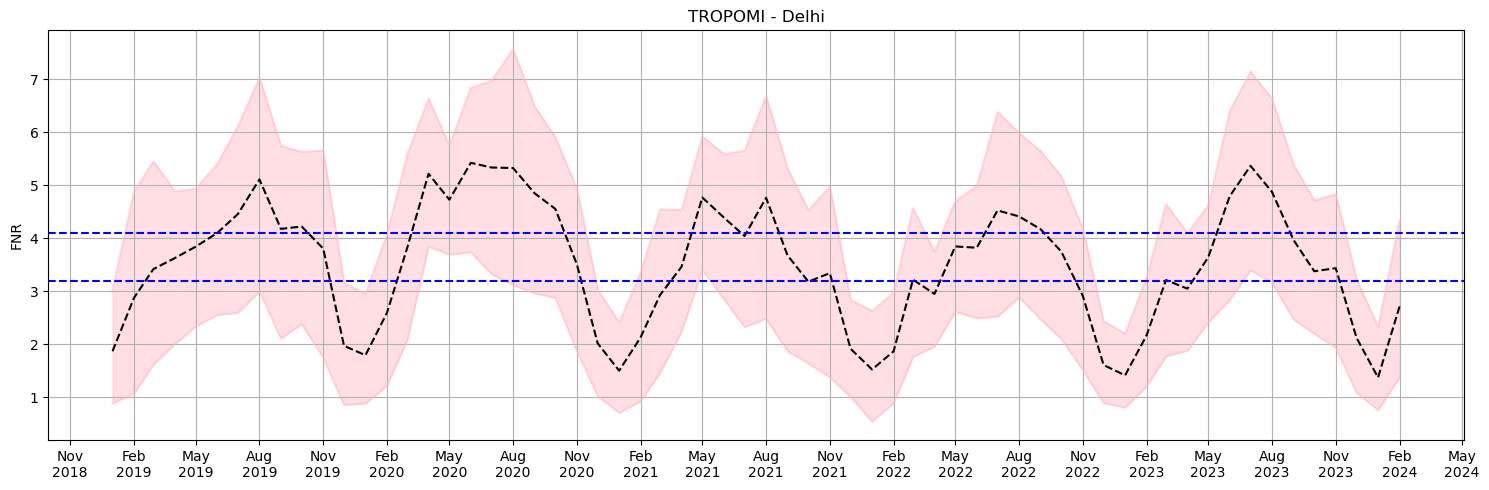

In [14]:
# start_date = pd.Timestamp(2019, 7, 1)
# end_date = pd.Timestamp(2019, 9, 1)

# df_filtered = ribbon_df[(ribbon_df['date'] >= start_date) & (ribbon_df['date'] <= end_date)]
# df_filtered = df_filtered.dropna()
f = create_ribbon_charts(ribbon_df, 'fnr', 'date',
                     'FNR','TROPOMI - Delhi')